1️⃣ Import Libraries & Load Data

In [1]:
# Import the modules
import psycopg2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sqlalchemy import create_engine
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from pathlib import Path
from tqdm import tqdm

In [2]:
# Define the connection parameters
host = 'localhost'  # or the IP address of your database server
dbname = 'StarsGalaxiesQuasars'  # Replace with your database name
user = 'postgres'  # Replace with your database username
password = 'postgres'  # Replace with your database password
port = '5432'  # Default PostgreSQL port

In [3]:
# Create the connection string
connection = f'postgresql://{user}:{password}@{host}:{port}/{dbname}'
 
# Create a connection engine using SQLAlchemy
engine = create_engine(connection)

In [4]:
# Write a SQL query to join the observation and classification tables
join_query = """
SELECT o.*, c.class
FROM observation o
JOIN classification c ON o.classid = c.classid;
"""

In [5]:
# Load the data into a Pandas DataFrame
database_df = pd.read_sql(join_query, engine)

# Check DataFrame
database_df.head()

,observationid,classid,objid,ra,dec,u,g,r,i,z,redshift,run,rerun,camcol,field,specobjid,plate,mjd,fiberid,class
0,1,1,1237650000000000000,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752.0,301,4,267,3.722360e+18,-8.96e-06,3306,54922,491,STAR
1,2,1,1237650000000000000,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752.0,301,4,267,3.638140e+17,-5.49e-05,323,51615,541,STAR
2,3,2,1237650000000000000,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752.0,301,4,268,3.232740e+17,0.1231112,287,52023,513,GALAXY
3,4,1,1237650000000000000,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752.0,301,4,269,3.722370e+18,-0.000110616,3306,54922,510,STAR
4,5,1,1237650000000000000,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752.0,301,4,269,3.722370e+18,0.000590357,3306,54922,512,STAR


2️⃣ Exploratory Data Analysis (EDA)

In [6]:
print(database_df.describe())

       observationid       classid            ra           dec             u  \
count    10000.00000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      5000.50000      1.669800    175.529987     14.836148     18.619355   
std       2886.89568      0.625465     47.783439     25.212207      0.828656   
min          1.00000      1.000000      8.235100     -5.382632     12.988970   
25%       2500.75000      1.000000    157.370946     -0.539035     18.178035   
50%       5000.50000      2.000000    180.394514      0.404166     18.853095   
75%       7500.25000      2.000000    201.547279     35.649397     19.259232   
max      10000.00000      3.000000    260.884382     68.542265     19.599900   

                  g             r             i             z      redshift  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      17.371931     16.840963     16.583579     16.422833    981.034800   
std        0.945457      1.067764      1.1

C:\Users\shiki\AppData\Local\Temp\ipykernel_12648\3098073525.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=database_df, x='class', palette='viridis')


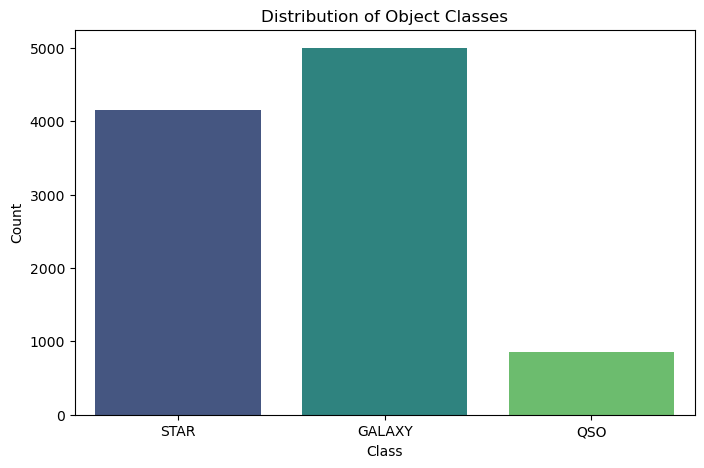

In [7]:
# Count plot of different classes
plt.figure(figsize=(8, 5))
sns.countplot(data=database_df, x='class', palette='viridis')
plt.title("Distribution of Object Classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

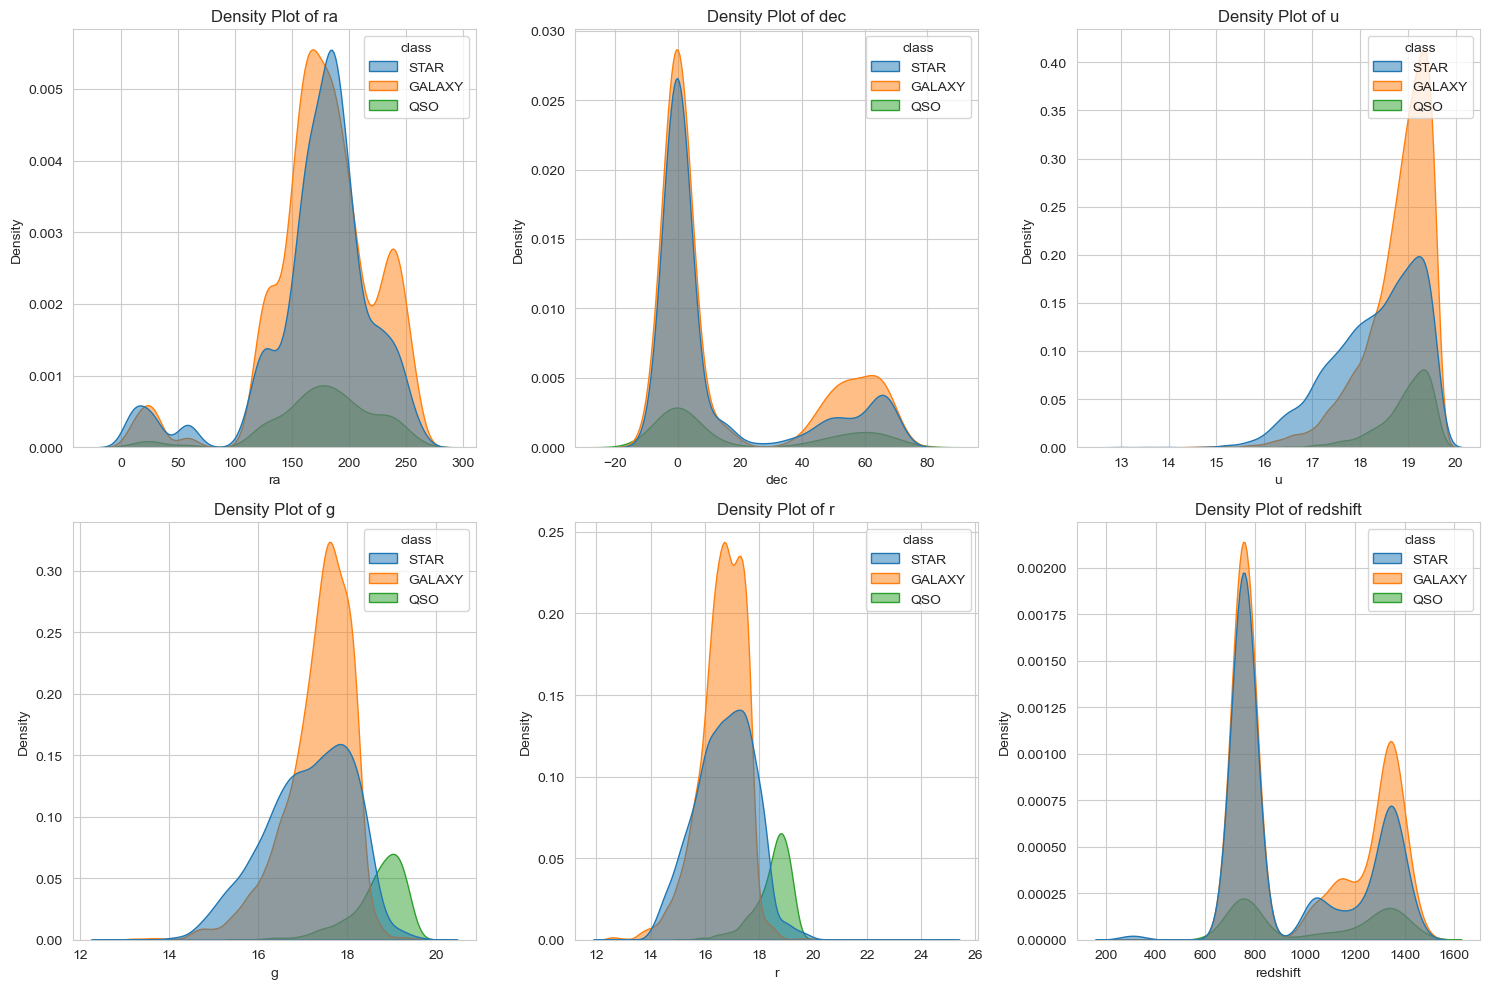

In [8]:
# Set plot style
sns.set_style("whitegrid")

# Density plots for numerical columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
features = ['ra', 'dec', 'u', 'g', 'r', 'redshift']
for i, feature in enumerate(features):
    row, col = divmod(i, 3)
    sns.kdeplot(data=database_df, x=feature, hue='class', fill=True, ax=axes[row, col], alpha=0.5)
    axes[row, col].set_title(f"Density Plot of {feature}")

plt.tight_layout()
plt.show()

In [9]:
# 3D Scatter Plot of RA, DEC, and Redshift
fig = px.scatter_3d(database_df, x='ra', y='dec', z='redshift', color='class', opacity=0.7)
fig.update_layout(title="3D Scatter Plot of RA, DEC, and Redshift")
fig.show()

In [10]:
database_df

,observationid,classid,objid,ra,dec,u,g,r,i,z,redshift,run,rerun,camcol,field,specobjid,plate,mjd,fiberid,class
0,1,1,1237650000000000000,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752.0,301,4,267,3.722360e+18,-8.96e-06,3306,54922,491,STAR
1,2,1,1237650000000000000,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752.0,301,4,267,3.638140e+17,-5.49e-05,323,51615,541,STAR
2,3,2,1237650000000000000,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752.0,301,4,268,3.232740e+17,0.1231112,287,52023,513,GALAXY
3,4,1,1237650000000000000,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752.0,301,4,269,3.722370e+18,-0.000110616,3306,54922,510,STAR
4,5,1,1237650000000000000,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752.0,301,4,269,3.722370e+18,0.000590357,3306,54922,512,STAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,2,1237650000000000000,131.316413,51.539547,18.81777,17.47053,16.91508,16.68305,16.50570,1345.0,301,3,161,5.033450e+17,0.02758294,447,51877,246,GALAXY
9996,9997,2,1237650000000000000,131.306083,51.671341,18.27255,17.43849,17.07692,16.71661,16.69897,1345.0,301,3,162,5.033400e+17,0.1177722,447,51877,228,GALAXY
9997,9998,1,1237650000000000000,131.552562,51.666986,18.75818,17.77784,17.51872,17.43302,17.42048,1345.0,301,3,162,8.222620e+18,-0.000401573,7303,57013,622,STAR
9998,9999,2,1237650000000000000,131.477151,51.753068,18.88287,17.91068,17.53152,17.36284,17.13988,1345.0,301,3,163,5.033400e+17,0.01401894,447,51877,229,GALAXY


3️⃣ Data Preprocessing

In [11]:
# Drop non-numeric columns except 'class'
ml = database_df.drop(columns=['observationid', 'classid', 'objid', 'specobjid', 'run', 'rerun', 'camcol', 'field', 'fiberid', 'plate', 'mjd'])

# Encode categorical target variable
le = LabelEncoder()
ml['class'] = le.fit_transform(ml['class'])

In [12]:
# Separate the data into labels and features
y = ml['class']
X = ml.drop(columns=['class'])

In [13]:
# Review the y variable Series
y.head()

0    2
1    2
2    0
3    2
4    2
Name: class, dtype: int32

In [14]:
# Review the target variable counts
y.value_counts()

class
0    4998
2    4152
1     850
Name: count, dtype: int64

In [15]:
# Review the X variable DataFrame
X.head()

,ra,dec,u,g,r,i,z,redshift
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752.0
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752.0
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752.0
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752.0
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752.0


In [16]:
# Review the feature variable counts
X.value_counts()

ra          dec         u         g         r         i         z         redshift
8.235100     14.704008  17.26167  16.06334  15.51514  15.29140  15.16316  1035.0      1
192.464970   0.198233   18.96585  17.54525  16.76086  16.35486  16.00846  752.0       1
192.266517   66.814214  19.02009  18.08086  17.56344  17.03533  16.96725  1412.0      1
192.386419  -0.376573   19.02828  17.04563  16.08323  15.62549  15.25828  752.0       1
192.399933   0.070941   18.67530  17.79995  17.54513  17.45599  17.45645  752.0       1
                                                                                     ..
163.216169  -0.050241   19.25595  18.23218  17.83592  17.68170  17.61131  756.0       1
163.219139   1.079843   19.48174  18.62244  18.35791  18.05260  17.95066  756.0       1
163.223825  -0.150001   19.52019  18.11852  17.28638  16.85283  16.58734  756.0       1
163.230449   0.780990   19.47643  17.99841  17.38878  17.15859  17.02192  756.0       1
260.884382   25.807214  18.01981  16.

In [17]:
# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)

Train set size: (8000, 8)
Test set size: (2000, 8)


In [18]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data and transform both train & test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for readability (optional)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

# Verify scaling
print("\nScaled Feature Mean (Train):\n", X_train_scaled.mean())
print("\nScaled Feature Standard Deviation (Train):\n", X_train_scaled.std())


Scaled Feature Mean (Train):
 ra         -2.700062e-16
dec         7.327472e-18
u           9.254819e-16
g          -4.297007e-15
r           2.774669e-15
i          -7.993606e-18
z          -6.794565e-17
redshift    2.116085e-16
dtype: float64

Scaled Feature Standard Deviation (Train):
 ra          1.000063
dec         1.000063
u           1.000063
g           1.000063
r           1.000063
i           1.000063
z           1.000063
redshift    1.000063
dtype: float64


In [19]:
# Check first few rows
X_train_scaled.head()

,ra,dec,u,g,r,i,z,redshift
0,-0.517787,-0.556383,0.093147,-0.553891,-0.889921,-0.983317,-1.107165,-0.821167
1,-0.304684,-0.535179,0.884337,0.118754,-0.164296,-0.310665,-0.432963,-0.821167
2,0.979421,-0.612357,0.424239,1.436133,1.595855,1.556812,1.415633,-0.835829
3,0.512531,-0.606563,0.821024,1.831825,1.816721,1.991200,2.056999,1.297476
4,0.404117,2.103266,0.724266,0.829808,0.683354,0.562247,0.492157,1.583383


4️⃣ Machine Learning Models

🔹 Logistic Regression


In [20]:
# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
logistic_model = LogisticRegression(random_state=12, max_iter=100)

# Fit the model using training data
logistic_model.fit(X_train, y_train)

c:\Users\shiki\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(random_state=12)

In [21]:
# Make a prediction using the testing data
y_pred = logistic_model.predict(X_test)

In [22]:
# Print the classification report for the model
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"\nLogistic Regression Model Report:\n{classification_report(y_test, y_pred)}")

Logistic Regression Accuracy: 0.6650

Logistic Regression Model Report:
              precision    recall  f1-score   support

           0       0.70      0.84      0.77       999
           1       0.49      0.21      0.30       169
           2       0.62      0.55      0.58       832

    accuracy                           0.67      2000
   macro avg       0.60      0.53      0.55      2000
weighted avg       0.65      0.67      0.65      2000



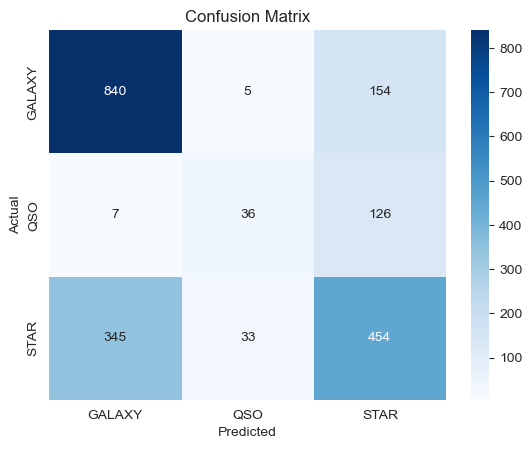

In [23]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

🔹 Random Forest Classifier


In [24]:
# Train Random Forest Model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose=2)
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=2)

In [25]:
# Predictions
y_pred_rf = rf.predict(X_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [26]:
# Evaluate model performance
print(f"Random Forest Model Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"\nRandom Forest Model Report:\n{classification_report(y_test, y_pred_rf)}")

Random Forest Model Accuracy: 0.91

Random Forest Model Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       999
           1       0.88      0.88      0.88       169
           2       0.89      0.92      0.91       832

    accuracy                           0.91      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.91      0.91      0.91      2000



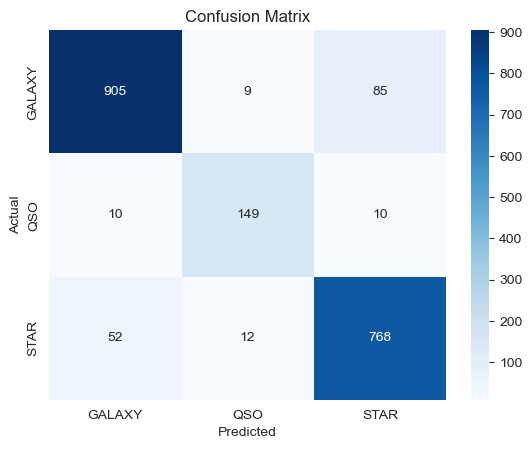

In [27]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

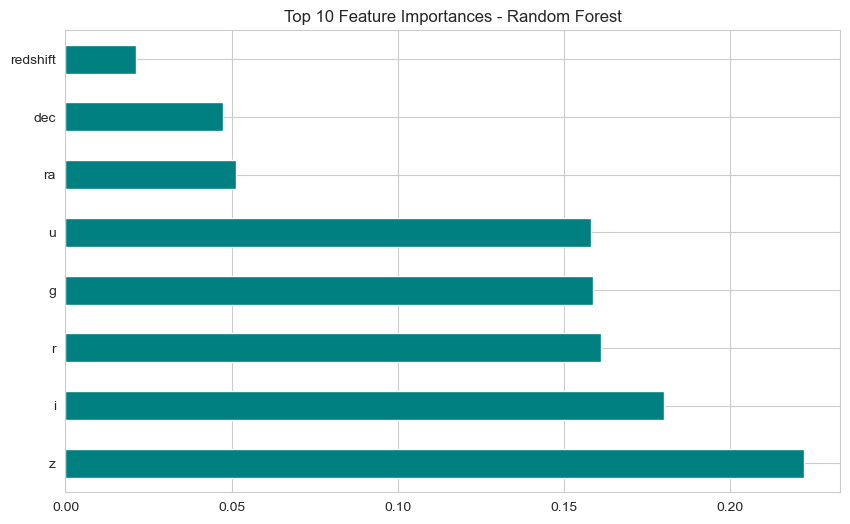

In [28]:
# Feature Importance Visualization
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', figsize=(10, 6), color='teal')
plt.title("Top 10 Feature Importances - Random Forest")
plt.show()

🔹 Support Vector Machine with SGD

In [29]:
# Initialize the model
svm_model = SGDClassifier(loss='hinge', random_state=100, max_iter=1, tol=None)
n_epochs = 100

print("\nTraining SVM with SGD:")
for epoch in tqdm(range(n_epochs), desc="Epoch Progress"):
    svm_model.partial_fit(X_train, y_train, classes=np.unique(y))


Training SVM with SGD:


Epoch Progress: 100%|██████████| 100/100 [00:00<00:00, 237.30it/s]


In [30]:
# Make predictions
y_pred = svm_model.predict(X_test)

In [31]:
# Evaluate the SVM model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.416

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       999
           1       0.00      0.00      0.00       169
           2       0.42      1.00      0.59       832

    accuracy                           0.42      2000
   macro avg       0.14      0.33      0.20      2000
weighted avg       0.17      0.42      0.24      2000



c:\Users\shiki\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\shiki\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\shiki\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



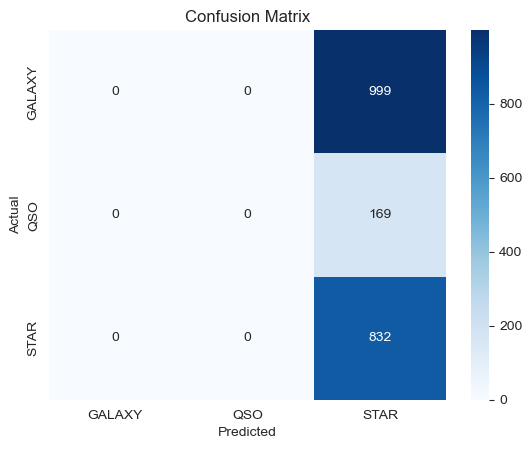

In [32]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Hyperparameter Tuning

In [33]:
# Define the Hyperparameter Tuning grid for SVM
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly']}

# Set up the SVC
svc = SVC()

In [37]:
# WARNING: THIS CODE CAN TAKE A WHILE TO RUN!
# Create a RandomizedSearchCV object with random_state for reproducibility and verbose for feedback
random_search = RandomizedSearchCV(
    svc, 
    param_grid, 
    n_iter=4, 
    cv=3, 
    scoring='accuracy', 
    n_jobs=-1,
    verbose=1, 
    random_state=634
)

# Create a custom fit method with progress bar
def fit_with_progress_bar(random_search, X_train, y_train):
    # Create a tqdm progress bar with the total number of fits (iterations)
    with tqdm(total=random_search.n_iter, desc="Randomized Search Progress", unit="trial") as pbar:
        best_score = -np.inf
        best_params = None
        
        # Manually iterate over n_iter and perform cross-validation for each parameter combination
        for _ in range(random_search.n_iter):
            # Generate a random set of parameters from the parameter grid
            params = random_search.param_distributions
            random_params = {key: np.random.choice(val) for key, val in params.items()}
            svc.set_params(**random_params)
            
            # Perform cross-validation for the current parameter combination
            cv = StratifiedKFold(n_splits=random_search.cv, shuffle=True, random_state=1)
            cv_scores = []
            for train_idx, test_idx in cv.split(X_train, y_train):
                X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
                y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]
                
                # Train and score the model for the fold
                svc.fit(X_train_fold, y_train_fold)
                cv_scores.append(svc.score(X_test_fold, y_test_fold))
            
            mean_score = np.mean(cv_scores)
            
            # Update the best score and parameters if applicable
            if mean_score > best_score:
                best_score = mean_score
                best_params = random_params
            
            # Update progress bar for each trial
            pbar.update(1)
        
        return best_params, best_score

# Run the randomized search with the progress bar
best_params, best_score = fit_with_progress_bar(random_search, X_train, y_train)

# Print the best parameters and score
print(f"Completed with random_state: {634}")
print("\nBest SVM Parameters:", best_params)
print("\nBest Score:", best_score)

Randomized Search Progress: 100%|██████████| 4/4 [01:46<00:00, 26.70s/trial]

Completed with random_state: 634

Best SVM Parameters: {'C': 10.0, 'kernel': 'linear'}

Best Score: 0.9377502793396136


In [38]:
# Train with linear kernel model
svm_linear = SVC(kernel='linear', random_state=42)
svm_linear.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [39]:
# Predictions
y_pred_linear = svm_linear.predict(X_test)

In [40]:
# Evaluate the linear Kernel Model
print("Linear Kernel Classification Report:")
print(classification_report(y_test, y_pred_linear))
print("Accuracy (linear Kernel):", accuracy_score(y_test, y_pred_linear))

Linear Kernel Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       999
           1       0.90      0.85      0.88       169
           2       0.91      0.97      0.94       832

    accuracy                           0.94      2000
   macro avg       0.93      0.92      0.92      2000
weighted avg       0.94      0.94      0.94      2000

Accuracy (linear Kernel): 0.9375


In [41]:
database_df

,observationid,classid,objid,ra,dec,u,g,r,i,z,redshift,run,rerun,camcol,field,specobjid,plate,mjd,fiberid,class
0,1,1,1237650000000000000,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752.0,301,4,267,3.722360e+18,-8.96e-06,3306,54922,491,STAR
1,2,1,1237650000000000000,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752.0,301,4,267,3.638140e+17,-5.49e-05,323,51615,541,STAR
2,3,2,1237650000000000000,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752.0,301,4,268,3.232740e+17,0.1231112,287,52023,513,GALAXY
3,4,1,1237650000000000000,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752.0,301,4,269,3.722370e+18,-0.000110616,3306,54922,510,STAR
4,5,1,1237650000000000000,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752.0,301,4,269,3.722370e+18,0.000590357,3306,54922,512,STAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,2,1237650000000000000,131.316413,51.539547,18.81777,17.47053,16.91508,16.68305,16.50570,1345.0,301,3,161,5.033450e+17,0.02758294,447,51877,246,GALAXY
9996,9997,2,1237650000000000000,131.306083,51.671341,18.27255,17.43849,17.07692,16.71661,16.69897,1345.0,301,3,162,5.033400e+17,0.1177722,447,51877,228,GALAXY
9997,9998,1,1237650000000000000,131.552562,51.666986,18.75818,17.77784,17.51872,17.43302,17.42048,1345.0,301,3,162,8.222620e+18,-0.000401573,7303,57013,622,STAR
9998,9999,2,1237650000000000000,131.477151,51.753068,18.88287,17.91068,17.53152,17.36284,17.13988,1345.0,301,3,163,5.033400e+17,0.01401894,447,51877,229,GALAXY


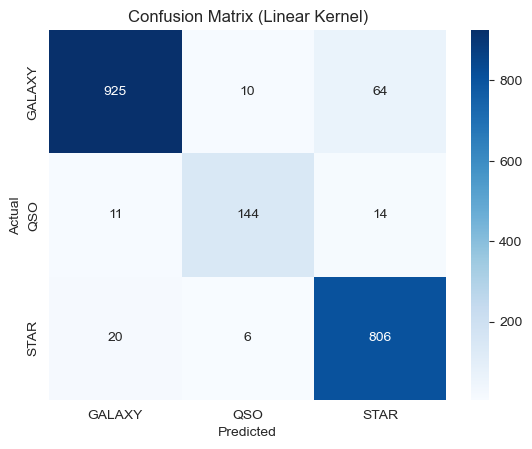

In [42]:
# Confusion Matrix
cm_rbf = confusion_matrix(y_test, y_pred_linear)
sns.heatmap(cm_rbf, annot=True, fmt="d", cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (Linear Kernel)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [43]:
# Train SVM with an RBF kernel
svm_rbf = SVC(kernel='rbf', random_state=42)
svm_rbf.fit(X_train, y_train)

SVC(random_state=42)

In [44]:
# Predictions
y_pred_rbf = svm_rbf.predict(X_test)

In [45]:
# Evaluate the RBF Kernel Model
print("RBF Kernel Classification Report:")
print(classification_report(y_test, y_pred_rbf))
print("Accuracy (RBF Kernel):", accuracy_score(y_test, y_pred_rbf))

RBF Kernel Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       999
           1       0.00      0.00      0.00       169
           2       1.00      0.01      0.02       832

    accuracy                           0.50      2000
   macro avg       0.50      0.34      0.23      2000
weighted avg       0.67      0.50      0.34      2000

Accuracy (RBF Kernel): 0.5035


c:\Users\shiki\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\shiki\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\shiki\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



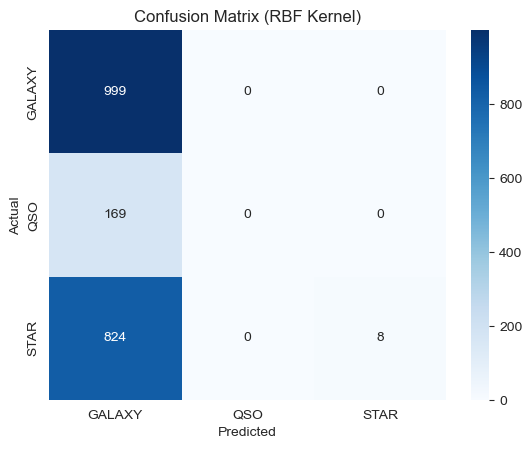

In [46]:
# Confusion Matrix
cm_rbf = confusion_matrix(y_test, y_pred_rbf)
sns.heatmap(cm_rbf, annot=True, fmt="d", cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (RBF Kernel)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

5️⃣ PCA for Dimensionality Reduction

In [47]:
# Apply PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

svm_model_pca = SGDClassifier(loss='hinge', max_iter=10000, tol=1e-3, verbose=1, random_state=100)
svm_model_pca.fit(X_train_pca, y_train)
y_pred_pca = svm_model_pca.predict(X_test_pca)

-- Epoch 1
Norm: 316.86, NNZs: 2, Bias: 348.139465, T: 8000, Avg. loss: 52764.395312
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 66.30, NNZs: 2, Bias: 349.242103, T: 16000, Avg. loss: 15502.467981
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 134.06, NNZs: 2, Bias: 365.485516, T: 24000, Avg. loss: 9431.059128
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 80.86, NNZs: 2, Bias: 369.111474, T: 32000, Avg. loss: 6732.329269
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 64.31, NNZs: 2, Bias: 357.866219, T: 40000, Avg. loss: 5203.915028
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 71.11, NNZs: 2, Bias: 318.509283, T: 48000, Avg. loss: 4254.993530
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 38.25, NNZs: 2, Bias: 317.773037, T: 56000, Avg. loss: 3757.480592
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 12.27, NNZs: 2, Bias: 302.349720, T: 64000, Avg. loss: 3128.005405
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 33.09, NNZs: 2, Bias: 287.96

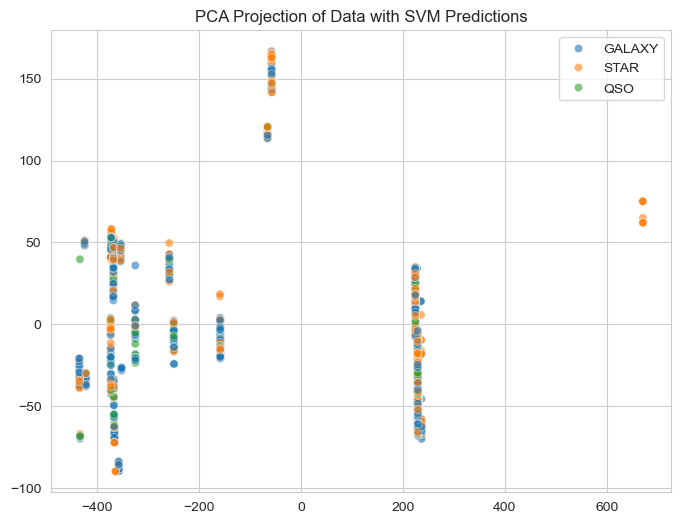

In [48]:
# Scatter plot of PCA projection
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=le.inverse_transform(y_test), alpha=0.6)
plt.title("PCA Projection of Data with SVM Predictions")
plt.show()